In [1]:
import os
import cv2
import laspy as lp
import numpy as np
import pyvista as pv 
import matplotlib.pyplot as plt

from PIL import Image
from scipy.interpolate import griddata
from numpy.polynomial.polynomial import Polynomial

In [2]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

In [3]:
import numpy as np
from scipy.spatial import KDTree

def remove_low_density_points(points, radius=0.1, min_neighbors=3):
    tree = KDTree(points)
    distances, _ = tree.query(points, k=min_neighbors, distance_upper_bound=radius)
    mask = np.all(distances < radius, axis=1)
    return mask #(N,3)

def remove_low_intensity_points(points):
    intensity_mean, intensity_std = np.mean(points), np.std(points)
    lower_threshold = intensity_mean - 2 * intensity_std
    upper_threshold = intensity_mean + 2 * intensity_std
    mask = (points > lower_threshold) & (points < upper_threshold)
    return mask

In [4]:
METHOD = 'mean'
POOL_NAME = '1B'
FRECUENCY = '100kHz'    
PROJECT_NAME = f'250111-100kHz_120m'
PATH_LAS = f'data/{FRECUENCY}/{PROJECT_NAME}/{POOL_NAME}/{POOL_NAME}_clasificada_col_0_row_0_sqm.las'
print(PATH_LAS)
OUTPUTS_PATH = f'discrete_model/{METHOD}/{PROJECT_NAME}/{POOL_NAME}'
LIMIT = -1

if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

data/100kHz/250111-100kHz_120m/RBS/RBS_clasificada_col_0_row_0_sqm.las


In [6]:
bottom_pools = {'RBS': 2300.26, 'RBN': 2300.46, '1B': 2300.54, 
               '2B': 2300.48, '4A': 2300.24, 'H13': 2300.05, 
               'H14': 2300.24, 'H15': '2300.01', 'H16': 2299.85, 
               'H17': 2299.24, 'K51': '2300.49', 'K52': 2300.46, 
               'K53': 2300.41, 'K54': '2300.38', 'HK13': 2300.77, 
               'HK14': 2300.54, 'K36': '2300.89', 'K37': 2300.51, 
               '9F': 2300.30, '9E': 2300.27, '11G': 2300.33, 
               '11F': 2300.27, '11JC': 2300.30, '10J': 2300.35, 
               '10I': 2300.18, '10H': 2300.34}

bottom_pool = bottom_pools.get(POOL_NAME, '')
print(bottom_pool)

2300.26


In [7]:
# Lectura del archivo las
las = read_las_file(PATH_LAS)

# Print de las dimensiones y atributos que tiene el archivo las
for dimension in las.point_format.dimensions:
    print(dimension.name)

X
Y
Z
intensity
return_number
number_of_returns
synthetic
key_point
withheld
overlap
scanner_channel
scan_direction_flag
edge_of_flight_line
classification
user_data
scan_angle
point_source_id
gps_time
red
green
blue
Amplitude
Reflectance
Deviation


In [8]:
points = np.vstack((las.x, las.y, las.z)).transpose()
colors = np.vstack((las.red, las.green, las.blue)).transpose()
colors_norm = normalize_colors(colors)
points_norm, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(points)  
bottom_pool_norm = (bottom_pool - z_min) / (z_max - z_min)
# En este stack, el indice -1 es el número de retornos, el -2 es el número de retorno y el -3 es la intensidad
data_points = np.hstack((points,
                         points_norm,
                         colors,
                         colors_norm,
                         np.expand_dims(las.Deviation, -1),
                         np.expand_dims(las.intensity, -1),
                         np.expand_dims(las.return_number, -1),
                         np.expand_dims(las.number_of_returns, -1)))

# Filtro de puntos basados en la rasante facilitada por SQM
# No pueden haber puntos por debajo de la rasante
data_points = data_points[data_points[:,2] > bottom_pool]

# One return: Puntos asociados a un haz de láser con un solo retorno (1)
one_return = data_points[(data_points[:,-1] == 1)]

# Two returns: Puntos asociados a un haz de láser con dos retornos (2)
# Two returns - 1: Puntos que corresponden al primer retorno de un haz de láser con dos retornos
# Two returns - 2: Puntos que corresponden al segundo retorno de un haz de láser con dos retornos
two_returns_1 = data_points[(data_points[:,-1] == 2) & (data_points[:,-2] == 1)]
two_returns_2 = data_points[(data_points[:,-1] == 2) & (data_points[:,-2] == 2)]

In [9]:
original_plotter = pv.Plotter()
original_plotter.add_points(data_points[:,:3], scalars=data_points[:,9:12], rgb = True, point_size=1)
original_plotter.show()

Widget(value='<iframe src="http://localhost:41813/index.html?ui=P_0x7b3b6425ad80_0&reconnect=auto" class="pyvi…

In [10]:
return_plotter = pv.Plotter()
#return_plotter.add_points(one_return[:,:3], color = 'red', point_size=1)
return_plotter.add_points(two_returns_1[:,:3], color = 'blue', point_size=1)
return_plotter.add_points(two_returns_2[:,:3], color = 'green', point_size=1)
return_plotter.show()

Widget(value='<iframe src="http://localhost:41813/index.html?ui=P_0x7b3ad08dc500_1&reconnect=auto" class="pyvi…

In [10]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd

def find_best_gmm(data, max_components=2, criterion='aic', **kwargs):
    '''
    Find the best number of components for a Gaussian Mixture Model using AIC or BIC. 
    '''

    n_components_range = range(1, max_components + 1)
    criterions, means = [], []

    if criterion not in ['aic', 'bic']:
        raise ValueError("Invalid criterion. Use 'bic' or 'aic'.")

    for n in n_components_range:
        try:
            gmm = GaussianMixture(n_components=n, **kwargs)
            gmm.fit(data)
            if criterion == 'bic':
                criterions.append(gmm.bic(data))
            else:
                criterions.append(gmm.aic(data))
            means.append(gmm.means_)
        except ValueError as e:
            print(f"Error fitting GMM with {n} components: {e}")
            break

    return n_components_range[np.argmin(criterions)], means[np.argmin(criterions)]

# La info usada es la de intensidad de los primeros retornos de los haces de láser con dos retornos
data = two_returns_1[:, -3].reshape(-1, 1)
# Para el caso del color, se está usando el valor del canal verde
color_data = two_returns_1[:, 10].reshape(-1, 1)

# Se busca el número óptimo de componentes para el modelo GMM de intensidad
best_n_components, best_means = find_best_gmm(data)
# Se busca el número óptimo de componentes para el modelo GMM de color
best_color_n_components, best_color_means = find_best_gmm(color_data)

# Pandas dataframe con el resumen de best_n_components y best_means para la intensidad y el color
columns = ['n_components', 'mean 1', 'mean 2']
summary = pd.DataFrame(columns=columns)
summary.loc['intensity'] = [best_n_components, best_means[0][0], best_means[1][0]]
summary.loc['color'] = [best_color_n_components, best_color_means[0][0], best_color_means[1][0]]
summary

,n_components,mean 1,mean 2
intensity,2.0,621.070241,1623.601054
color,2.0,0.798598,0.566853


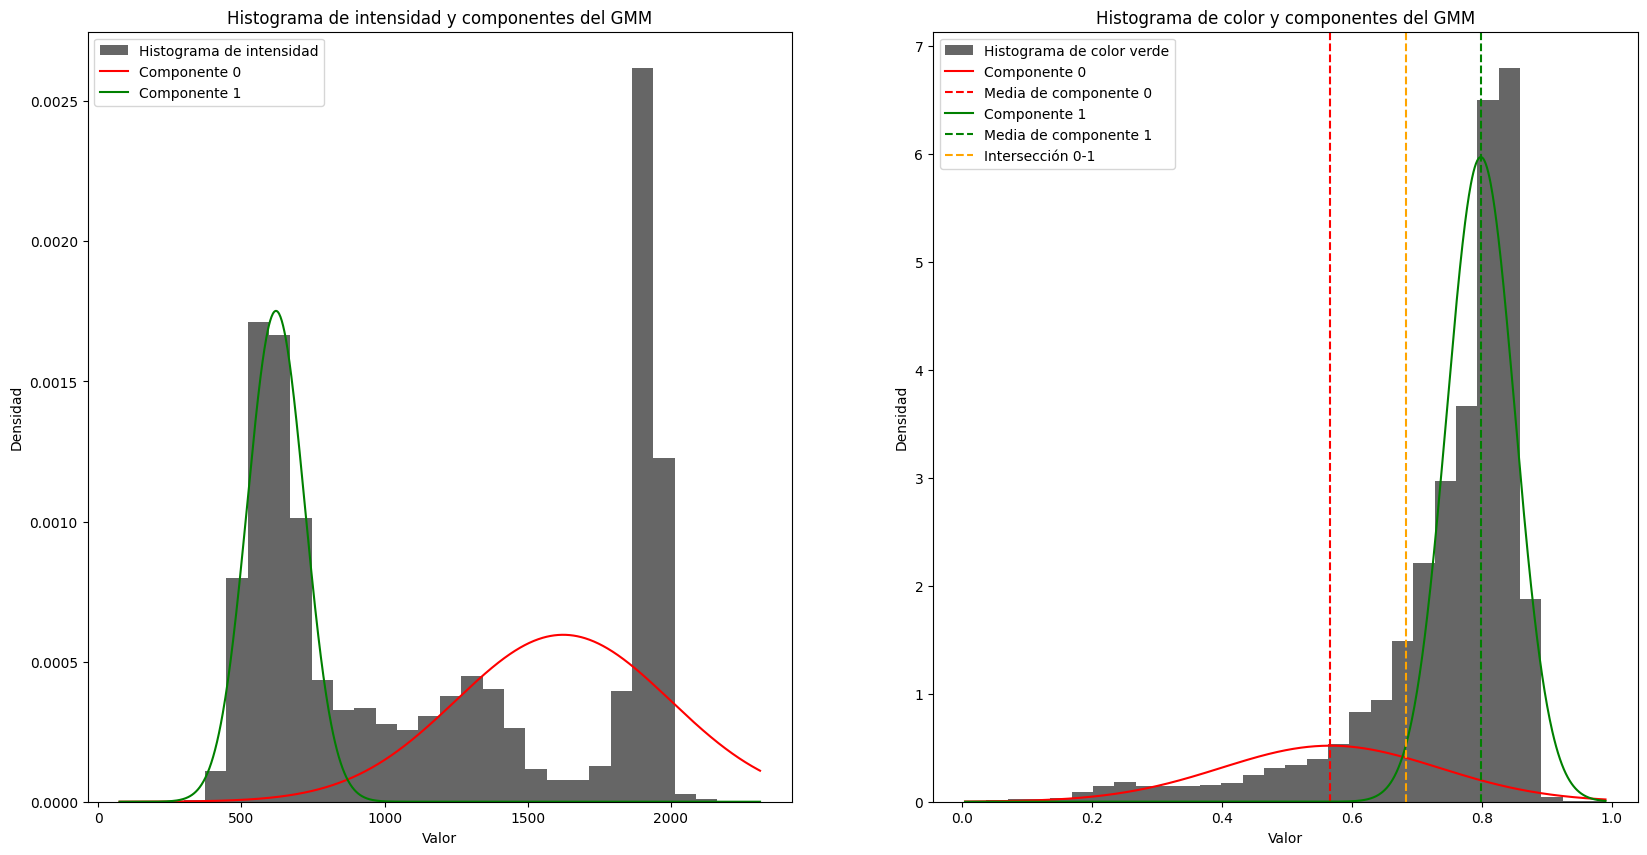

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=best_n_components, random_state=42)
gmm.fit(data)

gmm_color = GaussianMixture(n_components=best_color_n_components, random_state=42)
gmm_color.fit(color_data)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

def plot_intensity_and_color_gmm(int_data, int_gmm, int_best, color_data, color_gmm, color_best):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot intensity GMM
    axs[0].hist(int_data[:, 0], bins=30, density=True, alpha=0.6, color='k', label='Histograma de intensidad')
    x = np.linspace(min(int_data[:, 0]), max(int_data[:, 0]), 1000).reshape(-1, 1)
    logprob = int_gmm.score_samples(x)
    responsibilities = int_gmm.predict_proba(x)
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    for i in range(int_best):
        axs[0].plot(x, pdf_individual[:, i], label=f'Componente {i}', color=colors[i])
    
    axs[0].set_title('Histograma de intensidad y componentes del GMM')
    axs[0].set_xlabel('Valor')
    axs[0].set_ylabel('Densidad')
    axs[0].legend()

    # Plot color GMM
    axs[1].hist(color_data[:, 0], bins=30, density=True, alpha=0.6, color='k', label='Histograma de color verde')
    x = np.linspace(min(color_data[:, 0]), max(color_data[:, 0]), 1000).reshape(-1, 1)
    logprob = color_gmm.score_samples(x)
    responsibilities = color_gmm.predict_proba(x)
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    for i in range(color_best):
        axs[1].plot(x, pdf_individual[:, i], label=f'Componente {i}', color=colors[i])
        axs[1].axvline(color_gmm.means_[i], linestyle='--', label=f'Media de componente {i}', color=colors[i])

    for i in range(color_best - 1):
        axs[1].axvline((color_gmm.means_[i] + color_gmm.means_[i + 1]) / 2, color='orange', linestyle='--', label=f'Intersección {i}-{i+1}')
    
    axs[1].set_title('Histograma de color y componentes del GMM')
    axs[1].set_xlabel('Valor')
    axs[1].set_ylabel('Densidad')
    axs[1].legend()

    plt.show()

plot_intensity_and_color_gmm(data, gmm, best_n_components, color_data, gmm_color, best_color_n_components)

In [15]:
# Se selecciona el umbral de intensidad para el agua como el mínimo de las medias de los componentes del GMM de intensidad
water_intensity_t = np.min(best_means)
# Se selecciona el umbral de intensidad para los otros puntos como el máximo de las medias de los componentes del GMM de intensidad
other_points_intensity_t = np.max(best_means)

# Se selecciona el umbral de color para el promedio de los componentes del GMM de color verde
water_color_t = np.mean(best_color_means)
water_color_t_std = np.std(best_color_means)

# Se filtran los puntos de dos retornos que cumplen con las condiciones de intensidad y color
# Se declaran como puntos de agua aquellos que cumplen con que su intensidad es menor al umbral de intensidad
# y su color es mayor al umbral de color verde seleccionado
# Es decir, puntos con "baja" intensidad y "alto" color verde
#water_points = two_returns_1[(two_returns_1[:,-3] < water_intensity_t) & (two_returns_1[:,10] > water_color_t)]
water_points = two_returns_1[(two_returns_1[:,10] > water_color_t)]
#water_points = two_returns_1[(two_returns_1[:,-4] > 20) & (two_returns_1[:,-4] < 60)]

# Se declaran como puntos de ruido aquellos que cumplen con que su intensidad es mayor al umbral de intensidad para agua
# y menor al umbral de intensidad para otros puntos
noise_water = two_returns_1[(two_returns_1[:,-3] >= water_intensity_t) & (two_returns_1[:,-3] <= other_points_intensity_t)]

# ???
pool_bottom = two_returns_1[(two_returns_1[:,-3] < water_intensity_t)]

# Visualización de los puntos de agua y ruido
# Se visualizan los puntos de agua en azul y los de ruido en rojo
plotter = pv.Plotter()
#plotter.add_points(two_returns_1[:,:3], color='purple', point_size = 2)
water_color = water_points[:,9:12]
plotter.add_points(water_points[:,:3], scalars=water_color, rgb=True, point_size=2)
#plotter.add_points(noise_water[:,:3], color='red', point_size=2)
#plotter.add_points(pool_bottom[:,:3], color='green', point_size=2)
plotter.show()

Widget(value='<iframe src="http://localhost:35805/index.html?ui=P_0x798c4bccf680_4&reconnect=auto" class="pyvi…

Desviación estándar de la altura del agua: 0.3194546185583069
Media de la altura del agua: 2301.367455251732
Rango de la altura del agua: 1.3949999999999818


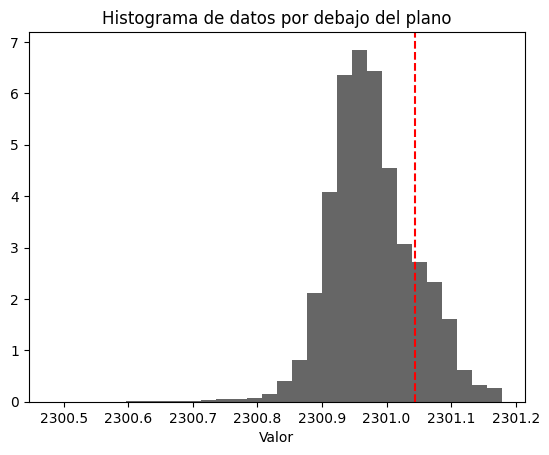

In [16]:
water_points_mask = (water_points[:, 5] >= np.mean(water_points[:, 5]) - 2 * np.std(water_points[:, 5])) & (water_points[:, 5] <= np.mean(water_points[:, 5]) + 2 * np.std(water_points[:, 5]))  # remove_low_density_points(water_points[:,:3], radius=0.3, min_neighbors=2)
water_points = water_points[water_points_mask]
# find water z deviation
water_points_z = water_points[:, 2]
water_points_std = np.std(water_points_z)
print(f"Desviación estándar de la altura del agua: {water_points_std}")
print(f"Media de la altura del agua: {np.mean(water_points_z)}")
print(f"Rango de la altura del agua: {np.max(water_points_z) - np.min(water_points_z)}")

other_points = np.vstack((one_return, two_returns_2, pool_bottom))
other_points_mask = remove_low_density_points(other_points[:,:3])
other_points = other_points[other_points_mask]

## ----- 
mean_of_water_points = np.mean(water_points[:,5], axis=0)

DELTA_WATER = mean_of_water_points * 0.1 #0.25 

distances = other_points[:, 5] - mean_of_water_points

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -DELTA_WATER
above_plane = distances >= DELTA_WATER

other_points_below = other_points[below_plane]
other_points_above = other_points[above_plane]

other_points_below_z = other_points_below[:, 2]
v_line = np.mean(other_points_below_z)+np.std(other_points_below_z)
plt.hist(other_points_below_z, bins=30, density=True, alpha=0.6, color='k', label='Histograma de datos')
plt.axvline(v_line, color='r', linestyle='--', label=f'Media de los puntos por debajo del plano')
plt.title('Histograma de datos por debajo del plano')
plt.xlabel('Valor')
plt.show()

In [17]:
other_points_below = other_points_below[other_points_below[:, 2] < np.mean(other_points_below[:, 2]) + np.std(other_points_below[:, 2])]

In [18]:
# plotter = pv.Plotter()

# water_points_pv = pv.PolyData(water_points[:,3:6])
# plotter.add_points(water_points_pv, color='blue', point_size=5)

# noise_water_pv = pv.PolyData(noise_water[:,3:6])
# plotter.add_points(noise_water_pv, color='red', point_size=5)

# points_1_pv = pv.PolyData(other_points[:,3:6])
# plotter.add_points(points_1_pv, color='green', point_size=5)

# points_pv = pv.PolyData(one_return[:,3:6])
# plotter.add_points(points_pv, color='yellow', point_size=5)

# plotter.show()

In [19]:
# Crear un plotter de PyVista
plotter = pv.Plotter()

water_points_pv = pv.PolyData(water_points[:,3:6])
plotter.add_points(water_points_pv, color='blue', point_size=5)


noise_pv = pv.PolyData(other_points_above[:,3:6])
plotter.add_points(noise_pv, color='red', point_size=5)

points_pv = pv.PolyData(other_points_below[:,3:6])
plotter.add_points(points_pv, color='green', point_size=5)

# plane at bottom_pool_norm
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)
Z = np.ones_like(X) * bottom_pool_norm
plane = pv.StructuredGrid(X, Y, Z)
plotter.add_mesh(plane, color='gray', opacity=0.5)

plotter.show()

Widget(value='<iframe src="http://localhost:35805/index.html?ui=P_0x798c4bdff5f0_5&reconnect=auto" class="pyvi…

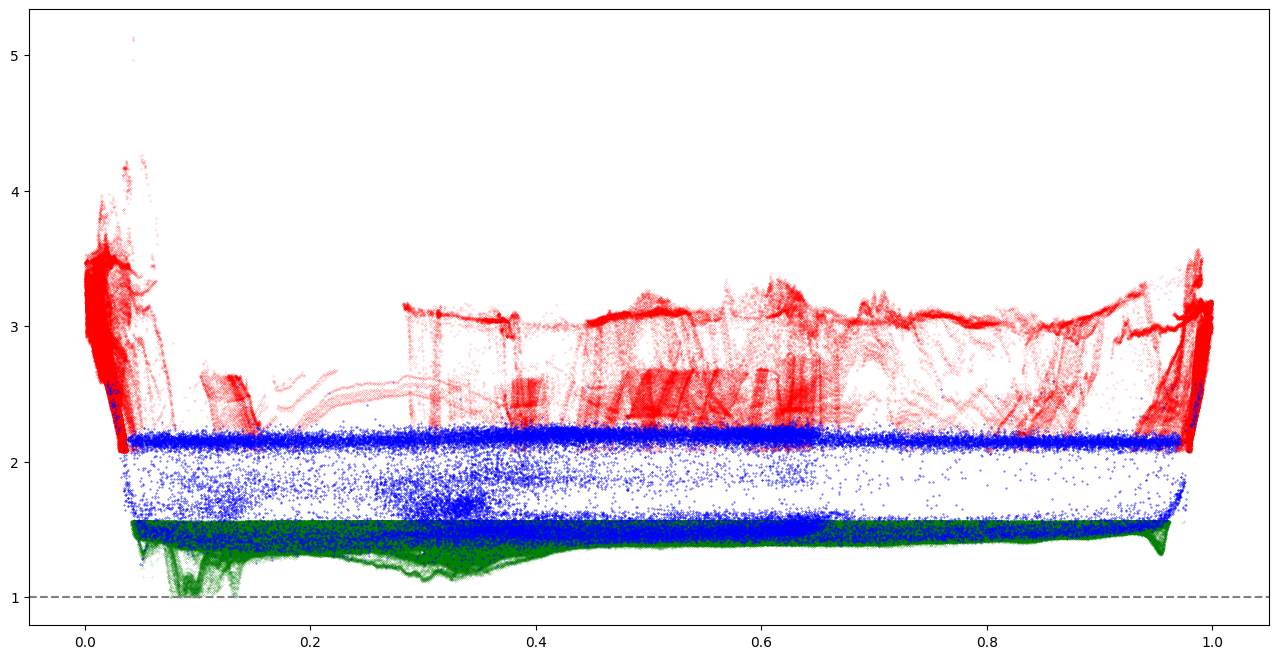

In [20]:
plt.figure(figsize=(16,8))
plt.scatter(other_points_above[:,3], other_points_above[:,5]*(z_max-z_min), c='red', s=0.01)
plt.scatter(other_points_below[:,3], other_points_below[:,5]*(z_max-z_min), c='green', s=0.01)
plt.scatter(water_points[:,3], water_points[:,5] *(z_max-z_min), c='blue', s=0.1)
# plot bottom_pool_norm
plt.axhline(bottom_pool_norm*(z_max-z_min), color='gray', linestyle='--', label='Bottom pool')
plt.show()  

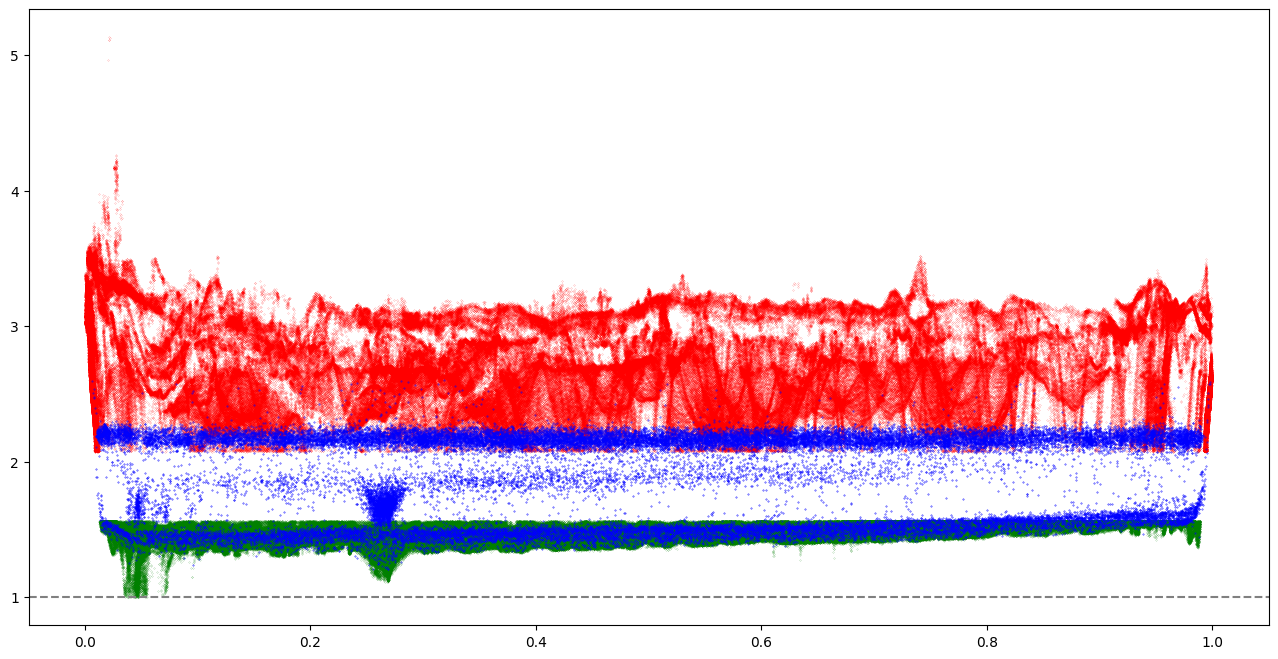

In [21]:
plt.figure(figsize=(16,8))
plt.scatter(other_points_above[:,4], other_points_above[:,5]*(z_max-z_min), c='red', s=0.01)
plt.scatter(other_points_below[:,4], other_points_below[:,5]*(z_max-z_min), c='green', s=0.01)
plt.scatter(water_points[:,4], water_points[:,5] *(z_max-z_min), c='blue', s=0.1)
# plot bottom_pool_norm
plt.axhline(bottom_pool_norm*(z_max-z_min), color='gray', linestyle='--', label='Bottom pool')
plt.show()  

In [45]:
points_below = other_points_below[:,3:6]

# Calcular las diagonales principales y secundarias
x_min_below = np.min(points_below[:, 0])
x_max_below = np.max(points_below[:, 0])
y_min_below = np.min(points_below[:, 1])
y_max_below = np.max(points_below[:, 1])

# Diagonal principal (de (x_min, y_min) a (x_max, y_max))>
diagonal1 = np.array([x_min_below, y_min_below, 0]), np.array([x_max_below, y_max_below, 0])

# Diagonal secundaria (de (x_min, y_max) a (x_max, y_min))
diagonal2 = np.array([x_min_below, y_max_below, 0]), np.array([x_max_below, y_min_below, 0])

# Función para calcular la distancia de un punto a una línea
def distance_to_line(points, line_start, line_end):
    x0, y0, z0 = points[:, 0], points[:, 1], points[:, 2]
    x1, y1, z1 = line_start
    x2, y2, z2 = line_end
    numerator = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

# Umbral de distancia para considerar que un punto está en la diagonal
threshold = 0.01

# Identificar los puntos que pertenecen a las diagonales
distances_diagonal1 = distance_to_line(points_below, diagonal1[0], diagonal1[1])
distances_diagonal2 = distance_to_line(points_below, diagonal2[0], diagonal2[1])

points_on_diagonal1 = points_below[distances_diagonal1 < threshold]
points_on_diagonal2 = points_below[distances_diagonal2 < threshold]

mask_on_diagonal1 = remove_low_density_points(points_on_diagonal1, radius=threshold, min_neighbors=10)
mask_on_diagonal2 = remove_low_density_points(points_on_diagonal2, radius=threshold, min_neighbors=10)

points_on_diagonal1 = points_on_diagonal1[mask_on_diagonal1]
points_on_diagonal2 = points_on_diagonal2[mask_on_diagonal2]


# Crear un plotter de PyVista
plotter = pv.Plotter()

# Añadir los puntos por debajo del plano en verde
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos en las diagonales en azul
points_on_diagonal1_pv = pv.PolyData(points_on_diagonal1)
points_on_diagonal2_pv = pv.PolyData(points_on_diagonal2)
plotter.add_points(points_on_diagonal1_pv, color='blue', point_size=10)
plotter.add_points(points_on_diagonal2_pv, color='red', point_size=10)

# Añadir pool_bottom_norm
plane = pv.StructuredGrid(X, Y, Z)
plotter.add_mesh(plane, color='gray', opacity=0.5)

# Mostrar el plotter
plotter.show()

Widget(value='<iframe src="http://localhost:44723/index.html?ui=P_0x702c63f68ef0_6&reconnect=auto" class="pyvi…

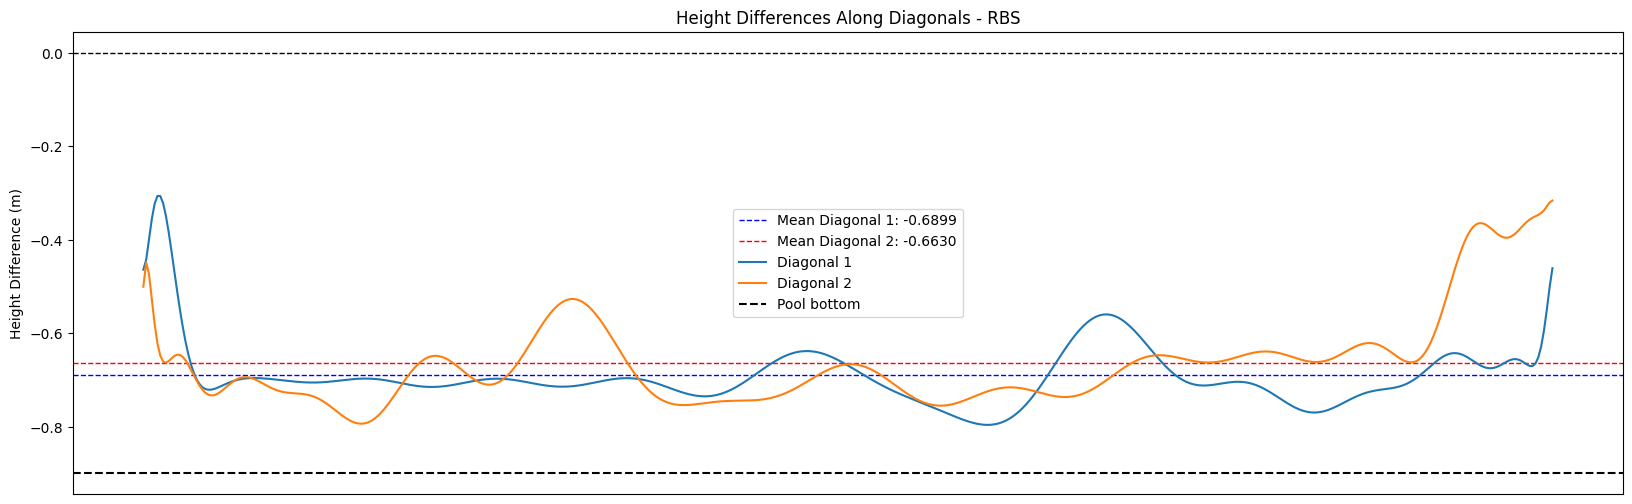

In [47]:
height_water = np.percentile(water_points[:,5], 50)

z_d1 = (height_water - points_on_diagonal1[:,2]) * (z_max - z_min) * -1
z_d2 = (height_water - points_on_diagonal2[:,2]) * (z_max - z_min) * -1
z_d2 = z_d2[::-1]

bottom_pool_norm_height = (height_water - bottom_pool_norm) * (z_max - z_min) * -1

degree = 30
poly_d1 = Polynomial.fit(np.arange(len(z_d1))/(len(z_d1)-1), z_d1, degree)
poly_d2 = Polynomial.fit(np.arange(len(z_d2))/(len(z_d2)-1), z_d2, degree)

x_new_d1 = np.linspace(0, 1, 500)
x_new_d2 = np.linspace(0, 1, 500)
z_new_d1 = poly_d1(x_new_d1)
z_new_d2 = poly_d2(x_new_d2)

mean_diagonal1 = np.mean(z_d1)
mean_diagonal2 = np.mean(z_d2)

plt.figure(figsize=(20, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Mean Diagonal 1: {mean_diagonal1:.4f}')
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Mean Diagonal 2: {mean_diagonal2:.4f}')
plt.plot(x_new_d1, z_new_d1, label='Diagonal 1')
plt.plot(x_new_d2, z_new_d2, label='Diagonal 2')
# add bottom pool norm
plt.axhline(bottom_pool_norm_height, color='black', linestyle='--', label='Pool bottom')
plt.ylabel('Height Difference (m)')
plt.title(f'Height Differences Along Diagonals - {POOL_NAME}')
plt.xticks([])
plt.legend()
plt.savefig(f'{OUTPUTS_PATH}/{POOL_NAME}_diagonals.png')
plt.show()

In [18]:
# plt.figure(figsize=(20, 6))
# plt.axhline(0, color='black', linestyle='--', linewidth=1)
# plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Mean Diagonal 1: {mean_diagonal1:.4f}')
# plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Mean Diagonal 2: {mean_diagonal2:.4f}')
# plt.plot(np.arange(len(z_d1))/(len(z_d1)-1), z_d1, label='Diagonal 1')
# plt.plot(np.arange(len(z_d2))/(len(z_d2)-1), z_d2, label='Diagonal 2')
# plt.ylabel('Height Difference (m)')
# plt.title(f'Height Differences Along Diagonals - {POOL_NAME}')
# plt.xticks([])
# plt.legend()
# plt.savefig(f'{OUTPUTS_PATH}/{POOL_NAME}_diagonals.png')
# plt.show()

In [49]:
z_points = (height_water - points_below[:,2]) * (z_max - z_min) * -1 
depth_mean_pool = np.mean(z_points)
depth_mean_pool

np.float64(-0.6586847619621681)

In [50]:
salt_z_points = ((((points_below[:,2]) * (z_max - z_min)) + z_min) - bottom_pool)
salt_mean_height = np.mean(salt_z_points)
salt_mean_height

np.float64(0.2403152356485861)

In [51]:
import json

file = {
    "height_water_normalized": height_water,
    "depth_pool": {
        "mean" :depth_mean_pool,
        "unit": "[m]"
    },
    "denormalize" : {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "z_min": z_min,
        "z_max": z_max
    },
    "diagonal1" : {
        "unit": "[m]",
        "mean": mean_diagonal1,
        "x_axis": x_new_d1.tolist(),
        "y_axis": z_new_d1.tolist(),
    },
    "diagonal2" : {
        "unit": "[m]",
        "mean": mean_diagonal2,
        "x_axis": x_new_d2.tolist(),
        "y_axis": z_new_d2.tolist(),
    }
}

#with open(f'{OUTPUTS_PATH}/{POOL_NAME}.json', 'w') as json_file:
#    json.dump(file, json_file, indent=4)

Grid Resolution: 1024 x 1094


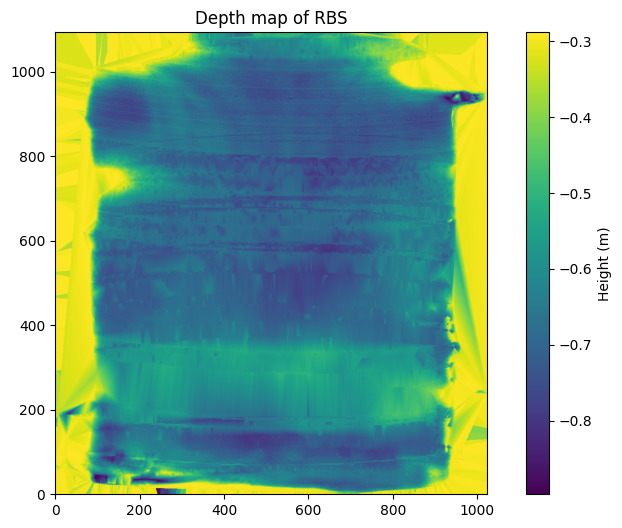

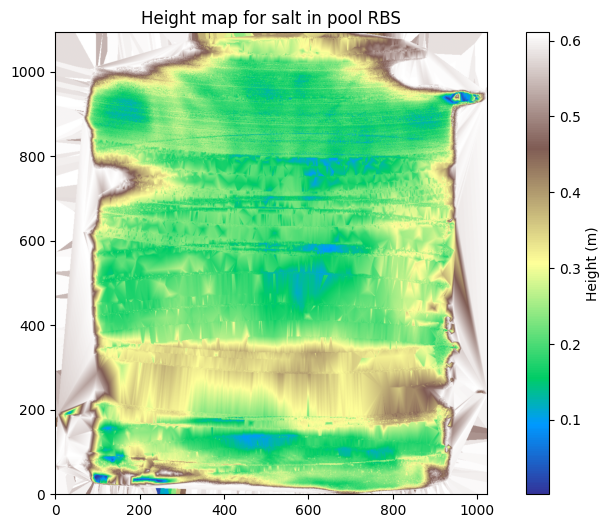

In [52]:
z = z_points 

x0, y0, z0 = water_points[:, 0], water_points[:, 1], water_points[:, 2]
x1, y1, z1 = points_below[:, 0], points_below[:, 1], points_below[:, 2]

grid_res_x = 1024  
x1_min, x1_max = x1.min(), x1.max()
y1_min, y1_max = y1.min(), y1.max()

grid_res_y = int(grid_res_x * (y1_max - y1_min) / (x1_max - x1_min))
print(f"Grid Resolution: {grid_res_x} x {grid_res_y}")

grid_x, grid_y = np.meshgrid(
    np.linspace(x1_min, x1_max, grid_res_x),
    np.linspace(y1_min, y1_max, grid_res_y)
)

# First interpolation using linear method
grid_z_linear = griddata((x1, y1), z, (grid_x, grid_y), method="linear") 
grid_z_linear_for_salt = griddata((x1, y1), salt_z_points, (grid_x, grid_y), method="linear")

# Second interpolation using nearest method to ensure complete surface
grid_z_nearest = griddata((x1, y1), z, (grid_x, grid_y), method="nearest") 
grid_z_nearest_for_salt = griddata((x1, y1), salt_z_points, (grid_x, grid_y), method="nearest")

# Combine the results to ensure complete surface
grid_z = np.where(np.isnan(grid_z_linear), grid_z_nearest, grid_z_linear)
grid_z_for_salt = np.where(np.isnan(grid_z_linear_for_salt), grid_z_nearest_for_salt, grid_z_linear_for_salt)

# Plotting the combined result
plt.figure(figsize=(10, 6))
plt.imshow(grid_z, origin='lower', cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title(f'Depth map of {POOL_NAME}')
plt.show()

# Plotting the combined result
plt.figure(figsize=(10, 6))
plt.imshow(grid_z_for_salt, origin='lower', cmap='terrain')
plt.colorbar(label='Height (m)')
plt.title(f'Height map for salt in pool {POOL_NAME}')
plt.show()

In [22]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = grid_z.astype(np.float32) 
#cv2.imwrite(f'{OUTPUTS_PATH}/{POOL_NAME}.exr', z_save)

pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'{OUTPUTS_PATH}/{POOL_NAME}.tiff')